Dataset link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

From this dataset, I build a Machine Learning model in Spark and Java to predict the house price.

In this section, I follow each steps below:

1. Foundation
- Set up environment
- Initial Spark Context
2. Explore and Preprocessing data
- Exploratory Data Analysis (EDA)
- Feature Selecting
- Missing Values Handling
- Feature Engineering: StringIndexing, OneHotEncoding, VectorAssembling methods
3. Train-Test Split
4. Choose Model for Training and Prediction
5. Evaluate The Model
6. Plot the Prediction value and Actual value

--------------------------------------------------------------

1. Foundation

In [2]:
import pyspark
import findspark
import numpy as np

In [3]:
from pyspark import SparkContext
sc = SparkContext(master = 'local')

from pyspark.sql import SparkSession
spark = SparkSession.builder \
          .appName("House Pricing Prediction") \
          .config("spark.some.config.option", "some-value") \
          .getOrCreate()

2. Explore and Preprocessing data

In [4]:
# Read data
hp = spark.read.csv('housprice.csv', header=True, inferSchema=True)
hp.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

- Exploratory Data Analysis

In [5]:
# Check the schema
hp.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

- The schema seems does not match with the value. Let's redefine it.

In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import col

hp = hp.withColumn("LotFrontage", col("LotFrontage").cast(IntegerType()))
hp = hp.withColumn("MasVnrArea", col("MasVnrArea").cast(IntegerType()))
hp = hp.withColumn("GarageYrBlt", col("GarageYrBlt").cast(IntegerType()))

In [7]:
# Summary statistics
hp.describe().show()

+-------+-----------------+------------------+--------+-----------------+------------------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+------------------+------------------+------------------+------------------+---------+--------+-----------+-----------+----------+------------------+---------+---------+----------+--------+--------+------------+------------+-----------------+------------+-----------------+-----------------+------------------+-------+---------+----------+----------+-----------------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+-----------+------------------+----------+------------------+-----------+----------+------------------+------------+------------------+-----------------+----------+----------+----------+------------------+-----------------+------------------+-----

Feature Selecting

- Select those features that have strong impact on the SellPrice value. (e.g. if it increase --> the price increase)
- Ignore those features that have imbalanced distribution between the values.
- Ignore those features that have too much NA values.

In [8]:
selected_features = ['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtQual', 'Electrical', '1stFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'SaleCondition' , 'SalePrice']

In [9]:
# Create new dataframe based on new selected feeatures
new_hp = hp.select(selected_features)
new_hp.show()

+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|LotFrontage|LotArea|Neighborhood|OverallQual|OverallCond|YearBuilt|YearRemodAdd|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|BsmtQual|Electrical|1stFlrSF|LowQualFinSF|BedroomAbvGr|KitchenQual|TotRmsAbvGrd|GarageArea|PavedDrive|WoodDeckSF|SaleCondition|SalePrice|
+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|         65|   8450|     CollgCr|          7|          5|     2003|        2003|    VinylSd|    VinylSd|   BrkFace|       196|       Gd|       T

- Missing Values Handling

In [10]:
# Define categorical/numerical features
numeric_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF']
categorical_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'Electrical', 'KitchenQual', 'PavedDrive', 'SaleCondition' ]

In [11]:
# Check the missing values
from pyspark.sql.functions import col, when, isnan, count

missing_values = new_hp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new_hp.columns])
missing_values.show()

+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|LotFrontage|LotArea|Neighborhood|OverallQual|OverallCond|YearBuilt|YearRemodAdd|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|BsmtQual|Electrical|1stFlrSF|LowQualFinSF|BedroomAbvGr|KitchenQual|TotRmsAbvGrd|GarageArea|PavedDrive|WoodDeckSF|SaleCondition|SalePrice|
+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|        259|      0|           0|          0|          0|        0|           0|          0|          0|         0|         8|        0|        

In [12]:
# Handle missing value
from pyspark.sql.functions import col, when, max

# With numerical attributes
# Convert 'NA' strings to null values for all numeric attributes
new_hp = new_hp.select([when(col(c) == 'NA', None).otherwise(col(c)).alias(c) for c in new_hp.columns])

# Fill null values with 0
new_hp = new_hp.fillna(0)

# With categorical attributes
# Fill null values in categorical attributes with the most frequent value
for column_name in categorical_cols:
    new_hp = new_hp.na.fill(new_hp.groupBy().agg(max(col(column_name))).collect()[0][0], subset=[column_name])


In [13]:
# Checking if there are any remaining missing values
missing_values = new_hp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new_hp.columns])
missing_values.show()

+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|LotFrontage|LotArea|Neighborhood|OverallQual|OverallCond|YearBuilt|YearRemodAdd|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|BsmtQual|Electrical|1stFlrSF|LowQualFinSF|BedroomAbvGr|KitchenQual|TotRmsAbvGrd|GarageArea|PavedDrive|WoodDeckSF|SaleCondition|SalePrice|
+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+
|          0|      0|           0|          0|          0|        0|           0|          0|          0|         0|         0|        0|        

Feature Engineering: StringIndexing, OneHotEncoding, VectorAssembling methods

In [14]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [15]:
indexers = [StringIndexer(inputCol=column, outputCol="indexed_"+column) for column in categorical_cols]
encoders = [OneHotEncoder(inputCol="indexed_"+column, outputCol="encoded_"+column) for column in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)

# fit and transform the pipeline
encoded_hp = pipeline.fit(new_hp).transform(new_hp)
encoded_hp.show(5)

+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+--------------------+-------------------+-------------------+------------------+-----------------+-----------------+----------------+------------------+-------------------+------------------+---------------------+--------------------+-------------------+-------------------+------------------+-----------------+-----------------+----------------+------------------+-------------------+------------------+---------------------+
|LotFrontage|LotArea|Neighborhood|OverallQual|OverallCond|YearBuilt|YearRemodAdd|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|BsmtQual|Electrical|1stFlrSF|LowQualFinSF|BedroomAbvGr|KitchenQual|TotRmsAbvGrd|GarageArea|PavedDrive|WoodDeckSF|SaleCondition|SalePrice|index

Select indexed columns

In [24]:
import re

# Define the pattern 
pattern = re.compile(r'^indexed_')

# Subtract the set of columns that match the pattern
indexed_columns = [col for col in encoded_hp.columns if pattern.match(col)]
indexed_columns

['indexed_Neighborhood',
 'indexed_Exterior1st',
 'indexed_Exterior2nd',
 'indexed_MasVnrType',
 'indexed_ExterQual',
 'indexed_ExterCond',
 'indexed_BsmtQual',
 'indexed_Electrical',
 'indexed_KitchenQual',
 'indexed_PavedDrive',
 'indexed_SaleCondition']

Select encoded columns

In [25]:
# Define the pattern 
pattern = re.compile(r'^encoded_')

# Subtract the set of columns that match the pattern
encoded_columns = [col for col in encoded_hp.columns if pattern.match(col)]
encoded_columns

['encoded_Neighborhood',
 'encoded_Exterior1st',
 'encoded_Exterior2nd',
 'encoded_MasVnrType',
 'encoded_ExterQual',
 'encoded_ExterCond',
 'encoded_BsmtQual',
 'encoded_Electrical',
 'encoded_KitchenQual',
 'encoded_PavedDrive',
 'encoded_SaleCondition']

In [26]:
# VectorAssembling
assembler = VectorAssembler(inputCols=numeric_cols + encoded_columns, outputCol="features")
hp2 = assembler.transform(encoded_hp)
hp2.show(5)

+-----------+-------+------------+-----------+-----------+---------+------------+-----------+-----------+----------+----------+---------+---------+--------+----------+--------+------------+------------+-----------+------------+----------+----------+----------+-------------+---------+--------------------+-------------------+-------------------+------------------+-----------------+-----------------+----------------+------------------+-------------------+------------------+---------------------+--------------------+-------------------+-------------------+------------------+-----------------+-----------------+----------------+------------------+-------------------+------------------+---------------------+--------------------+
|LotFrontage|LotArea|Neighborhood|OverallQual|OverallCond|YearBuilt|YearRemodAdd|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|BsmtQual|Electrical|1stFlrSF|LowQualFinSF|BedroomAbvGr|KitchenQual|TotRmsAbvGrd|GarageArea|PavedDrive|WoodDeckSF|SaleCond

In [28]:
# Redefine the dataframe for easy use
hp2.drop(*indexed_columns, *encoded_columns,*categorical_cols,*numeric_cols)
hp2 = hp2.select('features','SalePrice')
hp2.show(5)

+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|(93,[0,1,2,3,4,5,...|   208500|
|(93,[0,1,2,3,4,5,...|   181500|
|(93,[0,1,2,3,4,5,...|   223500|
|(93,[0,1,2,3,4,5,...|   140000|
|(93,[0,1,2,3,4,5,...|   250000|
+--------------------+---------+
only showing top 5 rows



3. Split data into training and test datasets

In [30]:
train_data, test_data = hp2.randomSplit([0.8, 0.2], seed=100)

4. Use Random Forest model to fit the data

In [31]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol="SalePrice", seed=56)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

5. Evaluate The Model

In [32]:
# Evaluate the model using RMSE and R-squared
rmse_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")

rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 34290.62534683671
R-squared (R²): 0.8434743328562527


6. Plot the prediction value and actual value

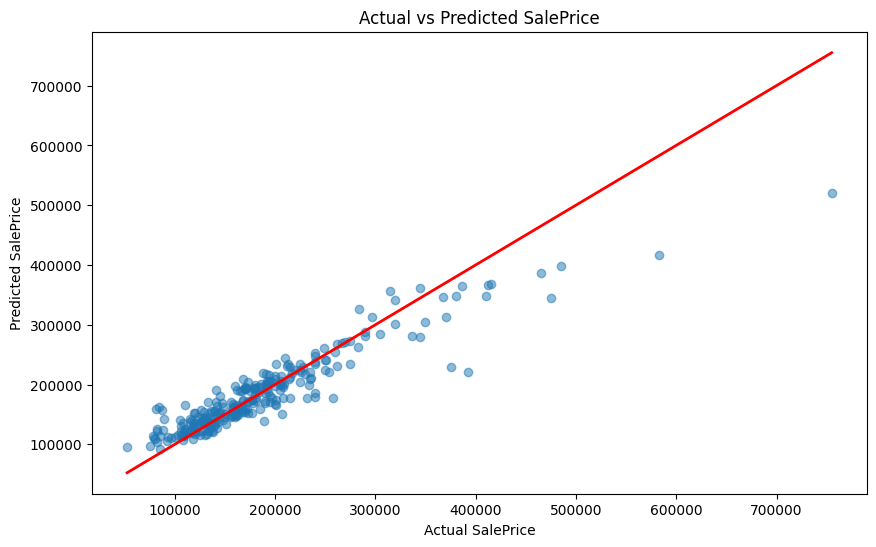

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
# Collect the predictions and actual values
predictions_df = predictions.select("prediction", "SalePrice").toPandas()
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["SalePrice"], predictions_df["prediction"], alpha=0.5)
plt.plot([predictions_df["SalePrice"].min(), predictions_df["SalePrice"].max()],
         [predictions_df["SalePrice"].min(), predictions_df["SalePrice"].max()],
         color='red', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()